<a href="https://colab.research.google.com/github/djthegr8/TensorFlowDatasetsDemo/blob/main/TDSTFData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to the TFDS and `tf.data` demo! 
This demo will take you through using a TFDS dataset and utilize the methods provided in `tf.data` for efficient data pipelines.     
Before you actually run this demo, please choose a Dataset from the [TFDS'](https://www.tensorflow.org/datasets/catalog/overview) catalog.    
Do take a look at the code running behind the forms and play around with it as you like!      
[Read the Medium article behind this notebook at this link!!](https://dj-ai.medium.com/youre-importing-data-wrong-c171f52eea00)       
<br />
<b><i>Thank you for using this Demo, hope you like it!</i></b><br />
<small>[Made by Dweep Joshipura](https://github.com/djthegr8)</small>

# Extract
The below code is responsible for extracting your chosen dataset, and decompressing it.

In [ ]:
#@markdown # Parameters for Extraction
#@markdown <b><i>Enter the name of the Dataset as noted from [TFDS](https://www.tensorflow.org/datasets/catalog/overview)</b></i>
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Replace caltech_birds2010 with the name of your selected dataset
ds_name = "caltech_birds2010" #@param {type:"string"}
#@markdown <b><i>Replace 0 with the Required Version number, or keep the below field empty for latest version</b></i>
# Replace 0 with the version of your dataset that you require, and set version_name to "" for the latest version
version_number =  "0" #@param {type:"string"}
version_name = ":" + version_number + ".*.*"
# I am using just the Train split, change it to "train+test" to use both combined or ["train","test"] to use both separately
#@markdown <b><i>Choose a split of the dataset, from either train, test or combined (i.e., train+test)</b></i>
split = "train" #@param ["train", "test", "train+test"]
# Get the dataset (extract)
dataset = tfds.load(ds_name + version_name,
                    split=split,
                    as_supervised=True)
#@markdown <b><i>Change this to number of classes of your model</b></i>
NUM_CLASSES =  200#@param {type:"number"}
#@markdown <i><b>Change this to your desired batch size     </b><i>
BATCH_SIZE = 32 #@param {type:"number"}
#@markdown <i><b>Set this to the required image size.</i></b><br /> Its recommended that if your dataset has a uniform size (eg. MNIST has 28 by 28), then set this to that. Else, set it to somewhere close to the <i>smallest image</i> in the dataset.
IMAGE_SIZE = 224 #@param {type:"number"}
#@markdown If your dataset consists of grayscale (or Black and White) images (for example, MNIST), then set the below to Grayscale, else keep it at colour.
IMAGE_TYPE = "Colour" #@param ["Colour","Grayscale"]
image_dims = 3
if IMAGE_TYPE == "Grayscale":
  image_dims = 1

Shuffling and writing examples to /root/tensorflow_datasets/caltech_birds2010/0.1.1.incompleteI0IFOL/caltech_birds2010-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/caltech_birds2010/0.1.1.incompleteI0IFOL/caltech_birds2010-test.tfrecord


Dataset caltech_birds2010 downloaded and prepared to /root/tensorflow_datasets/caltech_birds2010/0.1.1. Subsequent calls will reuse this data.


Below are a few helper functions, 

*   `def resize(image, label)` is for Resizing of the images to your selected image size for Uniformity, and     
*   `def one_hot(image, label)` is for conversion of labels into one-hot or categorical encoding. [Read more about one-hot here](https://medium.com/@michaeldelsole/what-is-one-hot-encoding-and-how-to-do-it-f0ae272f1179)
 

In [ ]:
def one_hot(image, label):
    """
    Converts the label to categorical.
    Arguments ~
        image: Tensor of Shape (IMAGE_SIZE,IMAGE_SIZE,image_dims) - Simply for outputting
        label: Tensor of Shape (BATCH_SIZE,) for casting and converting to categorical
    Returns the image (as it was inputted) and the label converted to a categorical vector
    """
    # Casts to an Int and performs one-hot ops
    label = tf.one_hot(tf.cast(label, tf.int32), NUM_CLASSES)
    # Recasts it to Float32
    label = tf.cast(label, tf.float32)
    return image, label
    
def resize(image,label):
  """
  Resizes the image to (IMAGE_SIZE,IMAGE_SIZE,image_dims) size
  Arguments:
      x: Tensor of Shape (None, None, image_dims) ~ The tensor to be resized
      y: Tensor of Shape (1,) ~ The ground truth label (not transformed, but required for inputting)
  Returns: A tuple of the Resized Image and Label
  """
  image = tf.image.resize(image,[IMAGE_SIZE,IMAGE_SIZE])
  return (image,label)

# Transform
The below code is applying a few transformations necessary for the Dataset, including ~

*   Resizing of image using the `resize` helper function,
*   Normalizing of the Image Values to between [0,1],
*   Shuffling the dataset,
*   Batching it using aforementioned Batch size,
*   And finally converting to categorical using the `one_hot` helper function



In [ ]:
# Performing a few Transformations

# As the Caltech Birds 2010 DataSet has Images of all different sizes, we will need to map them into (224,224,3) size
dataset = dataset.map(resize)

# Normalizing the datasets' values
dataset = dataset.map(lambda x,y: (x / 255,y))

# Shuffling the dataset 
dataset = dataset.shuffle(len(dataset))

# Batching the dataset
dataset = dataset.batch(BATCH_SIZE)

# Let's one-hot encode the labels using the previously written helper function
dataset = dataset.map(one_hot)
print("Preprocessing completed")

# Checking a few examples after one-hot
iters = dataset.take(2)
for example_feature,label in iters:
  print("The Batch is of shape {}, and the Ground truth labels are of shape {} after they are one-hot encoded".format(example_feature.shape,label.shape))


Preprocessing completed
The Batch is of shape (32, 224, 224, 3), and the Ground truth labels are of shape (32, 200) after they are one-hot encoded
The Batch is of shape (32, 224, 224, 3), and the Ground truth labels are of shape (32, 200) after they are one-hot encoded


Below is the code for a Deep CNN, it'll be overkill for a something like MNIST, but seems to fit Caltech Birds well.

In [ ]:
# The model is a Deep CNN with the below layers
"""    
Conv2D with 32 filters and (5,5) kernel,
ReLU activation,
Max Pooling with (2,2) pool size,
Conv2D with 16 filters of (3,3) kernel,
ReLU activation,
Max Pooling with (4,4) pool size,
Flattening to one dimension,
Batch Normalization,
256 unit Dense layer,
ReLU activation,
200 unit Dense layer,
Softmax activation
"""
my_model = tf.keras.models.Sequential(layers = [
                                     tf.keras.layers.Conv2D(32,(5,5),activation='relu',input_shape=(IMAGE_SIZE,IMAGE_SIZE,image_dims)),
                                     tf.keras.layers.MaxPool2D(),
                                     tf.keras.layers.Conv2D(16,(3,3),activation='relu'),
                                     tf.keras.layers.MaxPool2D((4,4)),
                                     tf.keras.layers.Flatten(),
                                     tf.keras.layers.BatchNormalization(),
                                     tf.keras.layers.Dense(256,activation='relu'),
                                     tf.keras.layers.Dense(NUM_CLASSES,activation='softmax')
],
name='ConvModel')

# Using the Categorical loss, and ADAM Optimizer
my_model.compile(
    'adam',
    'categorical_crossentropy',
    ['accuracy']
)
my_model.summary()

Model: "ConvModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 108, 16)      4624      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 11664)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 11664)             46656     
_________________________________________________________________
dense (Dense)                (None, 256)               29

# Load
Simply running `my_model.fit()` with the prepared dataset, and plotting the accuracy at the end. The model will be saved by the dataset's name, and you can download it in a later cell.

In [ ]:
#@markdown As the model is pretty <i>deep</i>, it overfits the Caltech Dataset in just under 10 epochs.         
#@markdown However, the complexity depends, so try out 10 epochs;   
#@markdown If you get less accuracy, rerun this cell with a higher value
NUM_EPOCHS = 10 #@param {type:"slider", min:1, max:40}

Epoch 1/10
94/94 [==============================] - 3s 36ms/step - loss: 5.4474 - accuracy: 0.0053
Epoch 2/10
94/94 [==============================] - 3s 35ms/step - loss: 5.2345 - accuracy: 0.0283
Epoch 3/10
94/94 [==============================] - 3s 35ms/step - loss: 4.2584 - accuracy: 0.1983
Epoch 4/10
94/94 [==============================] - 3s 35ms/step - loss: 2.0333 - accuracy: 0.5920
Epoch 5/10
94/94 [==============================] - 3s 35ms/step - loss: 0.7127 - accuracy: 0.8670
Epoch 6/10
94/94 [==============================] - 3s 35ms/step - loss: 0.2948 - accuracy: 0.9523
Epoch 7/10
94/94 [==============================] - 3s 35ms/step - loss: 0.1278 - accuracy: 0.9803
Epoch 8/10
94/94 [==============================] - 3s 35ms/step - loss: 0.0657 - accuracy: 0.9910
Epoch 9/10
94/94 [==============================] - 3s 35ms/step - loss: 0.0514 - accuracy: 0.9927
Epoch 10/10
94/94 [==============================] - 3s 35ms/step - loss: 0.0401 - accuracy: 0.9943


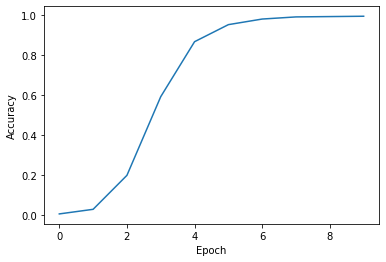

In [ ]:
# Now, we can run our model.fit()
History = my_model.fit(dataset,epochs=NUM_EPOCHS)

# We can trace the model's growth using the History variable
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
alpha = plt.plot(History.history['accuracy'])

# We can now save the model for further use.
my_model.save('./{}.h5'.format(ds_name))

In [ ]:
from google.colab import files
#@markdown # Download the model
#@markdown Tick the below checkbox if you wish to download your model
dload = False #@param {type:"boolean"}
if dload:
  files.download('./{}.h5'.format(ds_name))

# Thank you so much for using this demo!
### [*Made by Dweep Joshipura*](https://github.com/djthegr8)